# Исследовательский проект по НИС «Анализ данных в Python»
<div style="text-align: right">
    Проект подготовлен студентами БПИ228
    <br>
    Лысиным Кириллом и Гакал Анжеликой
</div>

## Часть 2. Сбор данных из интернета и составление датасета.
Данную часть задания мы выполняли первой, так как её результаты являются предметом аналаза в следующей части задания.

После обсуждения вариантов мы решили собирать информацию о товарах и услугах, размещённых на сервисе объявлений Юла.
Выбором данного сервиса объявлений обусловлен ряд решений в области реализации:
<br>
<p style="margin-left: 50px;">
    <ul>
        <li>Библиотека requests, пройденная на занятиях, не позволяет получить все необходимые данные со страницы, так как часть контента отображается только после выполнения js-скриптов, что не происходит при использовании вышеуказанной библиотеки, поэтому для получения данных с сайта исопльзуется библиотека selenium.</li>
        <li>Работа с динамически генерируемым содержимым сайта делает невозможной (или крайне затруднительной) унификацию процесса, так как для разных устройств это содержимое может отличаться. Этим фактом обусловлена заточенность прогаммы, осуществляющей парсинг, под конкретное устройство, но изменения, необходимые для работы программы на другом устройстве могут быть внесены за незначительный промежуток времени.</li>
    </ul>
</p>

In [2]:
import datetime
from selenium import webdriver
import pandas as pd
import time
from bs4 import BeautifulSoup
import os.path


    
driver = webdriver.Chrome()

with open('visited_links.txt', 'w+') as f:
    visited_links = set(f.readlines())


def get_item_info(url):
    
    info_dict = {}
    soup = get_soup(url)
    if(soup == None):
        return
    
    general_info = str(soup.findAll('meta', {'property':"og:description"})[0])

    # Сохранение данных о товаре/услуге в словарь
    info_dict['Name'] = get_item_name(general_info)
    info_dict['Price (in rubles)'] = get_item_price(general_info)
    info_dict['Category'] = get_item_category(general_info)
    info_dict['Region'] = get_item_region(soup)
    info_dict['Time/date of placement'] = get_item_placement_time(soup)
    info_dict['Added to favourites'] = get_favourites(soup)
    info_dict['Number of seller\'s ads'] = get_number_of_ads(soup)
    info_dict['Seller rating'] = get_seller_rating(soup)
    info_dict['Number of views'] = get_number_of_views(soup)
    info_dict['Number of images'] = get_number_of_images(soup)
    info_dict['Link'] = url
    
    return info_dict

def get_soup(url, counter = 0):

    time.sleep(1)
    try:
        driver.get(url)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        return soup
    # Если не удалось сразу получить страницу, то программа пробует еще несколько раз
    except:
        if(counter < 3):
            return get_soup(url, counter + 1)
    # Если после несольких попыток так и не удалось считать содержимое страницы, то этот метод вернет None

def get_item_name(info):
    try:
        name = info[15:info.find('–') - 1]
        return name
    except:
        return None

def get_item_price(info):
    try:
        if not('Цена: ' in info):
            return 0
        price = float(info[info.find('Цена: ') + 6:info.find('руб.') - 1].replace(' ', ''))
        return price
    except:
        return 0

def get_item_category(info):
    try:
        category = info[info.find('раздела «') + 9:info.find('».')]
        return category
    except:
        return None

def get_item_region(soup):
    try:
        region = list(soup.findAll('span', class_='sc-cOxWqc hNYaaO'))[0].text
        return region
    except:
        return None

def get_item_placement_time(soup):
    try:
        s = list(soup.findAll('dd', class_='sc-cOxWqc sc-fVmuvm eOPaPs dVayGV'))[-1].text
        now = datetime.datetime.now()
        if('Сегодня в' in s):
            return datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:]))
        if('Вчера в' in s):
            return (datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:])) + datetime.timedelta(days=-1))
        if('Позавчера в' in s):
            return (datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:])) + datetime.timedelta(days=-2))


        months = ['янв', 'фев', 'мар', 'апр', 'мая', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
        for j in range(len(months)):
            if(months[j].lower() in s):
                return datetime.datetime(now.year, j + 1, int(s[:2]), 12)
        return datetime.datetime(day=int(s[:2]), month=int(s[3:5]), year=int(s[6:10]), hour = 12)
    except:
        return None


def get_favourites(soup):
    try:
        favourites_count = list(soup.findAll('dd', class_="sc-cOxWqc sc-fVmuvm eOPaPs dVayGV"))
        return int(favourites_count[-3].text)
    except:
        return None

def get_number_of_ads(soup):
    try:
        n = list(soup.findAll('span', {'data-test-component':"UserNameClick"}))[0].text
        n = int(n[n.find('(')+1:n.find(' объявл')])
        return n
    except:
        return None

def get_seller_rating(soup):
    try:
        rating = soup.find('span', class_="sc-cOxWqc eDoIYl")
        return float(rating.text.replace(',', '.')) if rating != None else None
    except:
        return None

def get_number_of_views(soup):
    try:
        number_of_views = list(soup.findAll('dd', class_='sc-cOxWqc sc-fVmuvm eOPaPs dVayGV'))
        return int(number_of_views[-2].text)
    except:
        return None

def get_number_of_images(soup):
    try:
        images = list(soup.findAll('img', class_="sc-fBnnfK"))
        return len(images)
    except:
        return None

def get_links(scroll_count):
    
    url = r'https://youla.ru/'
    driver.get(url)
    time.sleep(1)
    
    for i in range(scroll_count):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    links = [str(i.a) for i in soup.findAll('span', class_="sc-llGDqb sc-gqgnwQ fEAASo hZGRky")]
    links = [r'https://youla.ru' + s[s.find(r'href="') + 6 : s.find(r'" rel')] for s in links]
    return links



n = 50
for i in range(n):
    items = []
    print(f"Processing batch {i + 1} out of {n}:", end='')
    links = get_links(1)
    for i in range(len(links)):
        if(int(i * 100/len(links))//5 > int((i - 1) * 100/len(links))//5):
            print(' .', end='')
        link = links[i]
        if(link in visited_links):
            continue
        items.append(get_item_info(link))
        visited_links.add(link)
    print(' ✓')

    df = pd.DataFrame(items)
    if(len(df) > 0):
        df = df.set_index('Name')
        if(os.path.isfile('items.xlsx')):
            prev_df = pd.read_excel('items.xlsx', index_col = 0)
            df = pd.concat([prev_df, df])

        df.to_excel('items.xlsx')

print("Done! The data has been saved to the file items.xlsx")

with open('visited_links.txt', 'a') as f:
    for line in visited_links:
        f.write(f"{line}\n")



driver.quit()
df

Processing batch 1 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 2 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 3 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 4 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 5 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 6 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 7 out of 50: . . . . . . . . . . . . ✓
Processing batch 8 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 9 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 10 out of 50: . . . . . . . . . . . . ✓
Processing batch 11 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 12 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 13 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 14 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 15

,Price (in rubles),Category,Region,Time/date of placement,Added to favourites,Number of seller's ads,Seller rating,Number of views,Number of images,Link
Name,,,,,,,,,,
Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...
Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...
Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...
Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...
Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...
...,...,...,...,...,...,...,...,...,...,...
Очки без диоптрий,300.0,Красота и здоровье,Москва,2023-02-03 17:17:00,0.0,3.0,5.0,0.0,4,https://youla.ru/moskva/krasota-i-zdorove/medi...
Новое платье паетки,1800.0,Женский гардероб,Москва,2023-02-03 11:01:00,0.0,173.0,5.0,1.0,5,https://youla.ru/moskva/zhenskaya-odezhda/plat...
Люстра 80-е годы,3000.0,Для дома и дачи,Москва,2023-01-27 12:00:00,0.0,6.0,5.0,15.0,3,https://youla.ru/moskva/dom-dacha/osveshchenie...


## Часть 1. Анализ датасета.

Загружаем содержимое файла items.xlsx, в котором содержатся данные, полученные в ходе выполнения части 2 проекта.  
Переименуем некоторые столбцы для удобства и выведем первые 5 строк датафрейма.

In [1]:
import pandas as pd

df = pd.read_excel("items.xlsx")
# Переименуем названия столбцов датасета для более удобного доступа к ним
df = df.rename(
    columns={
        'Time/date of placement': 'Placement_time',
        'Added to favourites': 'Favourites_count',
        'Number of views':'Views',
        'Number of images':'Images',
        'Price (in rubles)':'Price',
        'Number of seller\'s ads':'Ads_count',
        'Seller rating':'Seller_rating'
    })
df.head()


,Name,Price,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link
0,Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...
1,Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...
2,Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...
3,Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...
4,Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...


### Описание датасета

<i><b>- Определим размер датасета:</b></i>

In [2]:
size = df.shape
print(f"Количество строк (наблюдений): {size[0]}\n"+
     f'Количество столбцов (переменных): {size[1]}')

Количество строк (наблюдений): 10923
Количество столбцов (переменных): 11


<b><i>- Опишем переменные:</b></i>

In [3]:
columns = df.columns.to_list()
column_types = [str(i).ljust(15, ' ') for i in df.dtypes.to_list()]
na_count = [str(i) for i in df.isna().sum()]

s = [str(i) for i in df['Category']]
df['Category'] = s;
print("В датасете содержатся следующие переменные:")
print(*[('\t' + i).ljust(20, ' ') + "|тип данных переменной: " + j + "|число пустых значений: " + k for i, j, k in zip(columns, column_types, na_count)], sep='\n')

В датасете содержатся следующие переменные:
	Name               |тип данных переменной: object         |число пустых значений: 0
	Price              |тип данных переменной: float64        |число пустых значений: 0
	Category           |тип данных переменной: object         |число пустых значений: 0
	Region             |тип данных переменной: object         |число пустых значений: 28
	Placement_time     |тип данных переменной: datetime64[ns] |число пустых значений: 304
	Favourites_count   |тип данных переменной: float64        |число пустых значений: 301
	Ads_count          |тип данных переменной: float64        |число пустых значений: 370
	Seller_rating      |тип данных переменной: float64        |число пустых значений: 4909
	Views              |тип данных переменной: float64        |число пустых значений: 28
	Images             |тип данных переменной: int64          |число пустых значений: 0
	Link               |тип данных переменной: object         |число пустых значений: 0


<p style="margin-left:5em;">
    <ul>
        <li><em>Name</em> - Наименование товара/услуги. Категориальная переменная</li>  
        <li><em>Price</em> - цена товара/услуги в рублях. Метрическая переменная</li>  
        <li><em>Category</em> - категория товара. Категориальная переменная (Номинальная)</li>
        <li><em>Region</em> - местоположение продавца. Категориальная переменная (Номинальная)</li>
        <li><em>Placement_time</em> - дата и время размещения объявления. Метрическая переменная</li> 
        <li><em>Favourites_count</em> - количество людей, добавивших объявление в избранное. Метрическая переменная</li>
        <li><em>Ads_count</em> - количество объявлений, которые разместил продваец на сервисе. Метрическая переменная</li>
        <li><em>Seller_rating</em> - рейтинг продавца по пятибалльной шкале. Категориальная переменная (Порядковая)</li>
        <li><em>Views</em> - количество просмотров объявления. Метрическая переменная</li>
        <li><em>Images</em> - количество фотографий, прикреплённых к объявлению. Метрическая переменная</li>
        <li><em>Link</em> - ссылка на объявление</li>
    </ul>
</p>

<b><i>- Изменение типов данных:</i></b>
<br>Для данного датасета не нужно изменять типы данных в столбцах, так как он был составлен с учётом необходимости дальнейшего анализа.

### Добавление новых столбцов

Добавим новые колонки:
<ul>
    <li><em>Favourites_percent</em>, отражающую процент тех пользователей, которые добавили товар в избранное из числа людей, просмотревших объявление. (Категориальная (порядковая) переменная, тип значений в столбце - float64)</li>
    <li><em>Free_item</em>, показывающую, является ли товар/услуга бесплатной. (Категориальная (бинарная) переменная, тип значений в столбце - bool)</li>
</ul>

In [4]:
favourites_percent = [i/j * 100 if j != 0 else None for i, j in zip(df["Favourites_count"], df["Views"])]
free = [i == 0 for i in df["Price"]]
df['Favourites_percent'] = favourites_percent
df['Free_item'] = free
df.head()

,Name,Price,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
0,Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...,14.285714,True
1,Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000000,True
2,Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...,2.280130,True
3,Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...,0.000000,True
4,Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...,1.797191,True


<b><em>- Перекодирование переменных</em></b>
<br>
Добавим столбец <em>Price_range</em>, в котором перекодируем метрическую переменную <em>Price</em> в категориальную.
Все цены разделели на 5 категорий:
<ul>
    <li><em>free</em> - бесплатные товары</li>
    <li><em>small price</em> - недорогие товары (стоимостью до 5000 рублей)</li>
    <li><em>affordable</em> - товары среднего ценового сегмента (от 5000 до 15000 рублей)</li>
    <li><em>expensive</em> - дорогие товары (от 15000 до 100000 рублей)</li>
    <li><em>luxury</em> - товары роскоши (стоимостью более 100000 рублей)</li>
</ul>

In [5]:
price_range = ["free" if x == 0 else "small price" if x <= 5000 else "affordable" if x <= 15000 else "expensive" if x <= 100000 else "luxury" for x in df['Price']]
df.insert(2, 'Price_range', price_range)

In [6]:
df.head(10)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
0,Брюки 80-92,0.0,free,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...,14.285714,True
1,Туфли размер 30. Бесплатно,0.0,free,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000000,True
2,Кошка бесплатно,0.0,free,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...,2.280130,True
3,Demix на 6 лет на синтепоне,0.0,free,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...,0.000000,True
4,Красивый пёс в добрые руки,0.0,free,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...,1.797191,True
5,!Зимний конверт на выписку.,0.0,free,Детский гардероб,Апрелевка,2023-01-31 21:59:00,7.0,4.0,5.0,499.0,3,https://youla.ru/aprelevka/detskaya-odezhda/ko...,1.402806,True
6,Диски для гантелей,150.0,small price,Спорт и отдых,Москва,2023-01-31 14:51:00,0.0,607.0,5.0,3.0,3,https://youla.ru/moskva/sport-otdyh/trenazhery...,0.000000,False
7,6 16 коробка,100000.0,expensive,Легковые автомобили,Москва,2023-01-31 17:22:00,1.0,1.0,NaN,13.0,6,https://youla.ru/moskva/auto/s-probegom/6-16-k...,7.692308,False
8,"Подушки Бамбук новые, в упаковках",450.0,small price,Для дома и дачи,Москва,2023-01-31 12:58:00,160.0,9.0,NaN,3060.0,0,https://youla.ru/moskva/dom-dacha/tekstil-kovr...,5.228758,False
9,Щенки той пуделя Ркф -FCI,0.0,free,Животные,Москва,2023-01-28 12:00:00,11.0,1.0,NaN,476.0,5,https://youla.ru/moskva/zhivotnye/sobaki/shchi...,2.310924,True


<b><em>- Формирование среза таблицы и его транспонирование</em></b>

Выберем случайные 15 подряд идущих строк из датафрейма и транспонируем их.

In [7]:
import random as rand
k = rand.randint(0, size[0] - 15)
df.loc[k:k+15, :].T

,6757,6758,6759,6760,6761,6762,6763,6764,6765,6766,6767,6768,6769,6770,6771,6772
Name,Ремонт стиральных машин. Ремонт посудомоек,Шикарная туника⚘️⚘️⚘️,Обогреватель сентек кварцевый ct-6100,Бытовка 5 метровая (0),"Hyundai Santa Fe, 2011",Энчимелс,Ботинки горнолыжные Head Raptor RS flex 90 white,"Шиншилла (малыши), щенки шиншиллы","Квартира, 2 комнаты, 46.5 м²",Барный стул,"Кашпо Пень, крышка люка декоративная.",Куртка женская утепленная Беларусь 44 50 AVALON,Шапка мужская,"Volvo XC90, 2013",Диван,Питбайк 125 кубов
Price,300.0,24900.0,1540.0,60000.0,675600.0,650.0,18000.0,1990.0,4999998.0,1800.0,8200.0,6900.0,100.0,982800.0,3000.0,15000.0
Price_range,small price,expensive,small price,expensive,luxury,small price,expensive,small price,luxury,small price,affordable,affordable,small price,luxury,small price,affordable
Category,Услуги исполнителей,Женский гардероб,Бытовая техника,Стройматериалы и инструменты,Легковые автомобили,Детские товары,Спорт и отдых,Животные,Недвижимость,Для дома и дачи,Для дома и дачи,Женский гардероб,Мужской гардероб,Легковые автомобили,Для дома и дачи,Спецтехника и мотоциклы
Region,Химки,Троицк,Москва,Люберцы,Москва,Москва,Москва,Москва,"Щёлково, улица Полевая, 6А",Москва,Москва,Москва,Москва,Москва,Москва,Москва
Placement_time,2023-02-01 18:10:00,2023-01-28 12:00:00,2023-01-23 12:00:00,2023-01-31 12:00:00,2023-01-27 12:00:00,2023-01-30 12:00:00,2023-02-01 22:17:00,2023-02-01 08:04:00,2023-01-29 12:00:00,2023-02-02 20:35:00,2023-01-27 12:00:00,2023-02-02 19:42:00,2023-01-15 12:00:00,2023-02-02 16:25:00,2023-01-21 12:00:00,2023-02-02 20:35:00
Favourites_count,3.0,96.0,2.0,9.0,11.0,0.0,0.0,20.0,8.0,0.0,35.0,0.0,2.0,1.0,12.0,5.0
Ads_count,400.0,277.0,7319.0,334.0,185.0,207.0,359.0,2.0,12.0,46.0,296.0,19.0,38.0,185.0,1.0,11.0
Seller_rating,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,5.0,5.0,5.0,NaN,5.0,NaN,5.0,NaN
Views,38.0,9500.0,28.0,117.0,193.0,16.0,1.0,583.0,543.0,4.0,490.0,1.0,14.0,12.0,343.0,44.0


<b><em> - Многоуровневая сортировка</em></b>

Отсортируем датафрейм сначала по убыванию цены, а затем по убыванию количества просмотров. После этого выведем первые 20 наблюдений из отсортированного датасета.

In [8]:
sortedDf = df.dropna(subset = ['Price', 'Views']).sort_values(['Price', 'Views'], ascending=[False, False])
sortedDf.iloc[:20, :][['Price', 'Views']]

,Price,Views
7406,74900000.0,65.0
6649,40000000.0,2228.0
2320,40000000.0,2211.0
570,40000000.0,2184.0
9316,15000000.0,6041.0
5734,15000000.0,6038.0
5257,15000000.0,6036.0
7371,12000000.0,652.0
3546,12000000.0,648.0
2894,12000000.0,632.0


### Цель и задачи исследования

<b>Цель исследования:</b> проанализировать заинтересованность покупателей в товарах выбранных категорий, а также перспективы продавцов при реализации товаров в этих категориях.
<br><br>
<b>Задачи исследования:</b>
<ol>
    <li>Сформировать исследовательские гипотезы</li>
    <li>Построить графики, отражающие зависимость между выбранными переменными датасета</li>
    <li>Проанализировать данные, полученные на предыдущих этапах исследования</li>
    <li>Подтвердить или опровергнуть поставленные гипотезы</li>
</ol>

### Формирование исследовательских гипотез

<b>H1. </b>Рейтинг продавца зависит от количества размещённых объявлений<br>
<b>H2. </b>Объявления категории "Телефоны и планшеты" представлены наиболее широко - данная категория товаров является высоко конкурентной<br>
<b>H3. </b>Товары, относящиеся к предметам роскоши, составляют наибольший процент от всех товаров в Москве<br>


<b>H4. </b>Отношение услуг к товарам меньше 20%<br>
<b>H5. </b>Количество людей, добавивших товар в избранное, увеличивается с уменьшением цены.<br>
<b>H6. </b>Чем больше фотографий представлено в объявлении, тем больше процент людей, добавивших товар в избранное, из числа просмотревших<br>
<b>H7. </b>Количество людей, добавивших товар в избранное, зависит от рейтинга продавца.<br>
<b>H8. </b>Средняя цена на товары из категорий "Недвижимость", "Легковые автомобили", "Бытовыая техника", "Одежда" в Москве выше средней цены в других регионах<br> 
<b>H9. </b>На выходных активность продавцов на сайте выше<br>
<b>H10. </b>Заинтересованность покупателей в бесплатных товарах в выбранных категориях выше, чем в платных.<br>

### Проверка гипотез

<h4><b>H1. </b>Рейтинг продавца зависит от количества размещённых объявлений</h4>
Сначала исключим те строки, данные о рейтинге в которых пропущены.

In [9]:
ratingDf = df.dropna(subset = ['Seller_rating'])

Посчитаем значение корреляции между рейтингом продавца и количеством объявлений.

0.01868


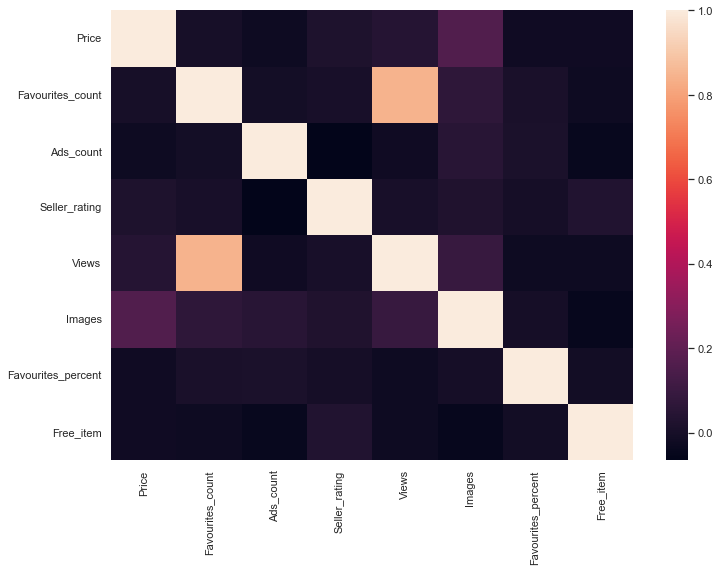

In [172]:
import seaborn as sns
sns.heatmap(ratingDf.corr())
print(f"{ratingDf['Seller_rating'].corr(ratingDf['Price']):.5f}")

Корреляция между рейтингом и количеством объявлений продавца отсутствует - <i><u>гипотеза не подтвердилась.</u></i>  
Построенная диаграмма показывает, что в данном датасете сильная корреляция наблюдается только между количеством людей, добавивших товар в избранное, и количеством просмотров объявления. Также присутствует слабая корреляция между ценой товара и числом изображений, прикреплённых к объявлению. Корреляция между другими столбцами отсутсвует, это может быть связано с тем фактом, что датасет содержит данные о товарах из множества разных категорий и те корреляции, которые могли бы присутствовать при рассмотрении конкретной категории, не проявляются

<h4><b>H2. </b>Объявления категории "Телефоны и планшеты" представлены наиболее широко - данная категория товаров является высоко конкурентной</h4>
Посчитаем количество товаров и услуг в каждой категории.

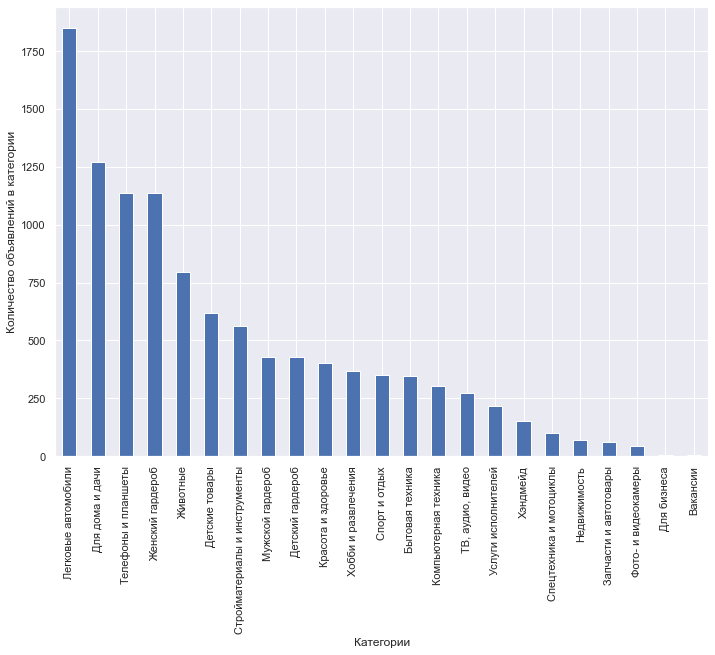

Category
Легковые автомобили             1849
Для дома и дачи                 1269
Телефоны и планшеты             1138
Женский гардероб                1135
Животные                         796
Детские товары                   618
Стройматериалы и инструменты     564
Мужской гардероб                 430
Детский гардероб                 429
Красота и здоровье               404
Хобби и развлечения              367
Спорт и отдых                    352
Бытовая техника                  346
Компьютерная техника             303
ТВ, аудио, видео                 272
Услуги исполнителей              216
Хэндмейд                         152
Спецтехника и мотоциклы           99
Недвижимость                      70
Запчасти и автотовары             60
Фото- и видеокамеры               44
Для бизнеса                        6
Вакансии                           4
dtype: int64

In [181]:
import matplotlib.pyplot as plt
category_counts = df.value_counts("Category")
ax = category_counts.plot(kind="bar")
ax.set_xlabel("Категории")
ax.set_ylabel("Количество объявлений в категории")
plt.show()
category_counts

<i>Гипотеза не подтвердилась.</i><br>
Категория "Телефоны и планшеты" находится лишь на третьем месте по количеству объявлений (1138 объявлений), её превосходят категории "Для дома и дачи" (1269 объявлений) и "Легковые автомобили" (1849 объявлений). Все 3 упомянутых категории товаров высоко конкуретны, это значит, что большие перспективы откроются продавцам в других категориях.


<h4><b>H3. </b>Товары, относящиеся к предметам роскоши, составляют наибольший процент от всех товаров в Москве по сравнению с другими регионами</h4>


<BarContainer object of 9 artists>

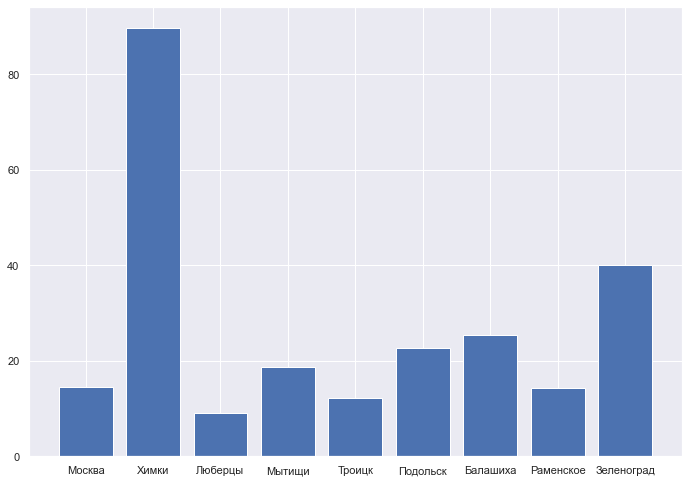

In [35]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.options.mode.chained_assignment = None
dfRegion = df.dropna(subset=["Region"])
dfRegion["Region"] = dfRegion["Region"].map(lambda x: "Москва" if ("Москва" in x) else x)

# Будем рассматривать регионы, в которых есть хотя бы 20 объявлений
multipleOccurences = []
luxuryPercent = []
temp = {}
regions = []

for i in dfRegion["Region"].unique():
    
    if(dfRegion.Region.value_counts()[i] > 20):
        regions.append(i)
        luxuryCount = dfRegion[(dfRegion["Price_range"] == "luxury") & (dfRegion["Region"] == i)].shape[0]
        totalCount = dfRegion[(dfRegion["Region"] == i)].shape[0]
        luxuryPercent.append(luxuryCount / totalCount * 100)


plt.bar(regions, luxuryPercent)

<i>Гипотеза не подтвердилась</i> - по графику видно, что товары роскоши в Москве составляют около 15% всех товаров, в то время как в некоторых других регионах эта цифра может достигать 30-40%, а в Химках около 95%, что является интересной аномалией.<br><i>Исследуем причины её возникновения:</i>

In [37]:
dfRegion[dfRegion["Region"] == "Химки"].head(15)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
1,Туфли размер 30. Бесплатно,0.0,free,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000000,True
88,"ВАЗ (Lada) Largus, 2018",545000.0,luxury,Легковые автомобили,Химки,2023-01-30 12:22:00,0.0,311.0,NaN,6.0,14,https://youla.ru/himki/auto/s-probegom/vaz-lad...,0.000000,False
193,"Hyundai Creta, 2021",1219000.0,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,0.0,312.0,NaN,22.0,9,https://youla.ru/himki/auto/s-probegom/hyundai...,0.000000,False
255,"Kia Sorento, 2014",980000.0,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,4.0,308.0,NaN,66.0,14,https://youla.ru/himki/auto/s-probegom/kia-sor...,6.060606,False
316,"Geely Atlas, 2018",990000.0,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,0.0,292.0,NaN,96.0,14,https://youla.ru/himki/auto/s-probegom/geely-a...,0.000000,False
317,"Land Rover Discovery, 2011",1040000.0,luxury,Легковые автомобили,Химки,2023-01-19 12:00:00,0.0,313.0,NaN,86.0,9,https://youla.ru/himki/auto/s-probegom/land-ro...,0.000000,False
319,"Land Rover Freelander, 2011",890000.0,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,1.0,315.0,NaN,35.0,14,https://youla.ru/himki/auto/s-probegom/land-ro...,2.857143,False
320,"Geely Atlas, 2018",1140000.0,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,0.0,292.0,NaN,13.0,14,https://youla.ru/himki/auto/s-probegom/geely-a...,0.000000,False
327,"Kia Optima, 2017",700000.0,luxury,Легковые автомобили,Химки,2023-01-25 12:00:00,19.0,308.0,NaN,495.0,14,https://youla.ru/himki/auto/s-probegom/kia-opt...,3.838384,False
365,"Kia Cee'd, 2016",755000.0,luxury,Легковые автомобили,Химки,2023-01-11 12:00:00,1.0,311.0,NaN,33.0,14,https://youla.ru/himki/auto/s-probegom/kia-cee...,3.030303,False


Можно заметить, что в представленном датафрейме по городу Химки содержится много записей о товарах категории "Легковые автомобили", покажем это на круговой диаграмме:

<AxesSubplot:title={'center':'Процент товаров по категориям'}>

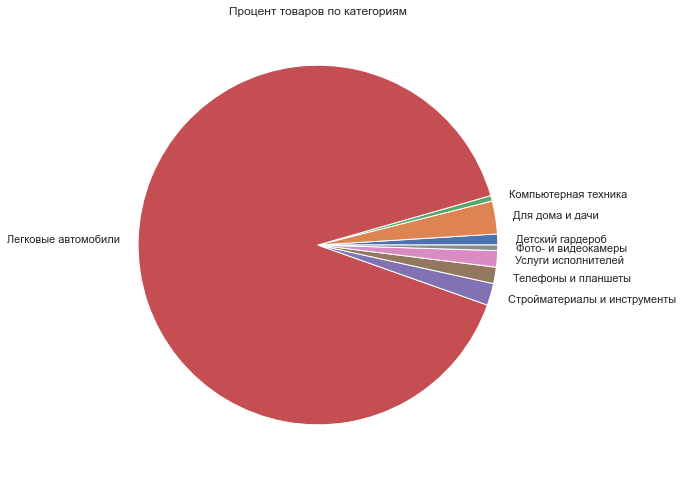

In [45]:
dfRegion[dfRegion["Region"] == "Химки"].groupby('Category').size().plot(kind='pie', title = "Процент товаров по категориям", ylabel = "")

Построенная диаграмма делает очевидным тот факт, что в городе Химки есть крупный продавец легковых автомобилей, поэтому значительная часть товаров в этом городе относится к категории роскоши.

<h4><b>H4. <b>Отношение услуг к товарам меньше 20%</h4>

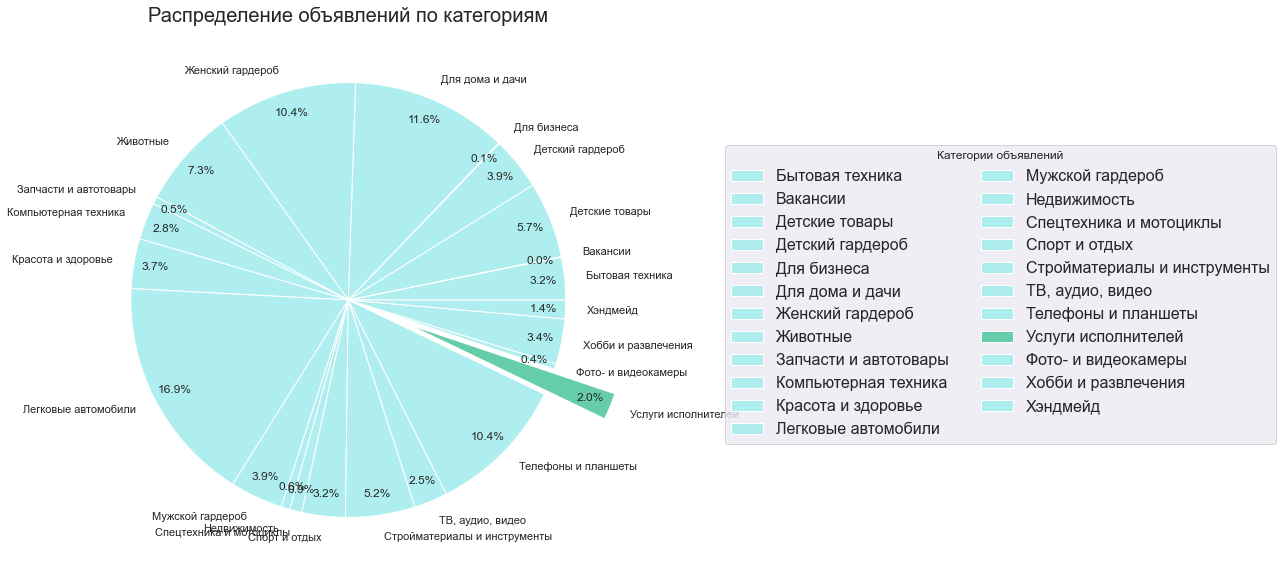

Отношение услуг к товарам составляет 2.017%


In [151]:
import matplotlib.pyplot as plt
categoriesSeries = df.groupby('Category').size()
plt.figure(figsize=(10, 10))

plt.pie(
    categoriesSeries,
    explode = [0.3 if i == 19 else 0 for i in range(23)],
    labels = categoriesSeries.index, 
    colors = ['mediumaquamarine' if i == 19 else 'paleturquoise' for i in range(23)],
    autopct='%.1f%%',
    pctdistance=0.9
    )
plt.title("Распределение объявлений по категориям", fontdict = {'fontsize' : 20})
plt.legend(categoriesSeries.index, 
           loc='upper center', 
           bbox_to_anchor=(1.7, 0.8),
           ncol=2,
           fontsize = 16,
           title = "Категории объявлений"
          )

plt.show()
percentage = df[df["Category"] == "Услуги исполнителей"].shape[0] / df[df["Category"] != "Услуги исполнителей"].shape[0] * 100
print(f"Отношение услуг к товарам составляет {percentage:.3f}%")

<i>Гипотеза подтвердилась</i> - отношение услуг у товарам примерно равно 2%, это может говорить как о недостаточной представленности объявлений в данной категории и о потенциально не занятой нише на данном сайте, так и о невостребованности услуг в сравнении с товарами на Юле, что может быть связано с тем, что существуют более таргетированные сайты по размещению услуг.  
Полученная круговая диаграмма также дает информацию о том, что товары категорий "Легковые автомобили", "Телефоны и планшеты", "Для дома и дачи" и "Женский гардероб" представлены на сайте особо широко.

<h4>H5. Количество людей, добавивших товар в избранное, увеличивается с уменьшением цены.</h4>

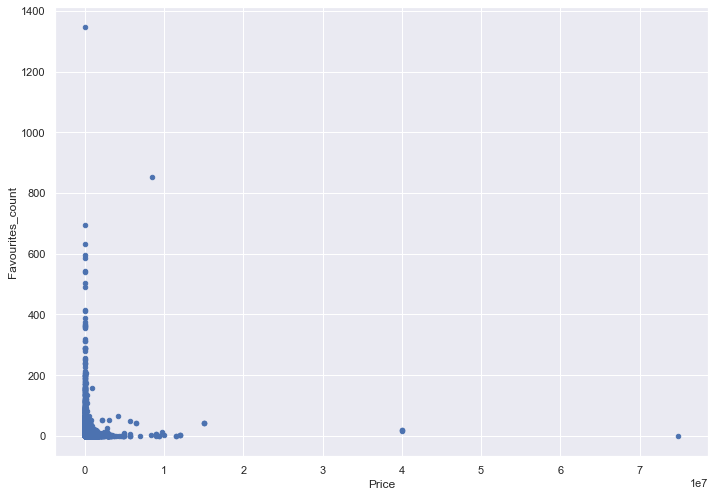

In [157]:
df.plot.scatter(x = "Price", y = "Favourites_count")
plt.show()

Данная диаграмма рассеяния неудобна для анализа, поэтому исключим строки с данными о бесплатных товарах, а также отфильтруем выбросы (объявления, которые добавили в избранное более 500 раз или цена которых превышает 10000000 рублей)

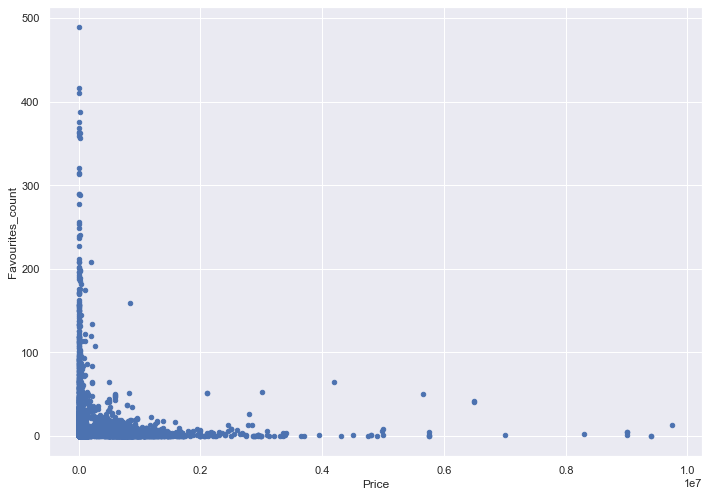

-0.024038183634301016


In [170]:
df[(~df["Free_item"]) & (df["Favourites_count"] < 500) & (df["Price"] < 10000000)].plot.scatter(x = "Price", y = "Favourites_count")
plt.show()

# Проблема: по графику корреляция как будто очевидна, но .corr() говорит, что корреляция отсутсвует
filtered = df[(~df["Free_item"]) & (df["Favourites_count"] < 500) & (df["Price"] < 10000000)]
print(filtered["Price"].corr(filtered["Favourites_count"]))

Гипотеза подтвердилась / была опровергнута

<h4>H6. Чем больше фотографий представлено в объявлении, тем больше процент людей, добавивших товар в избранное, из числа просмотревших</h4>


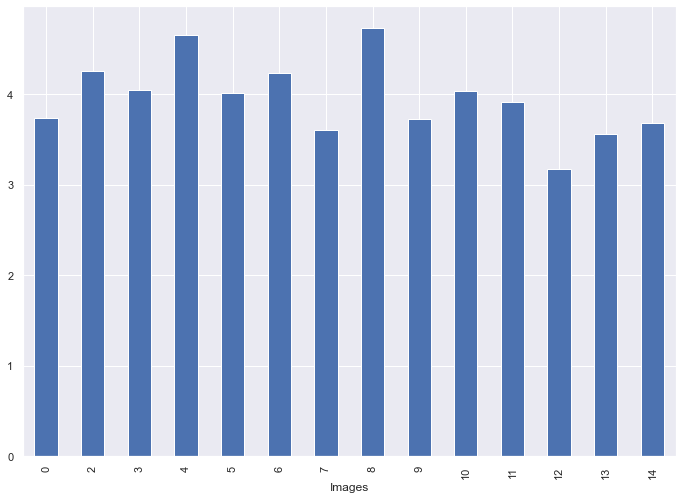

In [190]:
df.groupby("Images")["Favourites_percent"].mean().plot(kind = "bar")
plt.show()

Детский гардероб


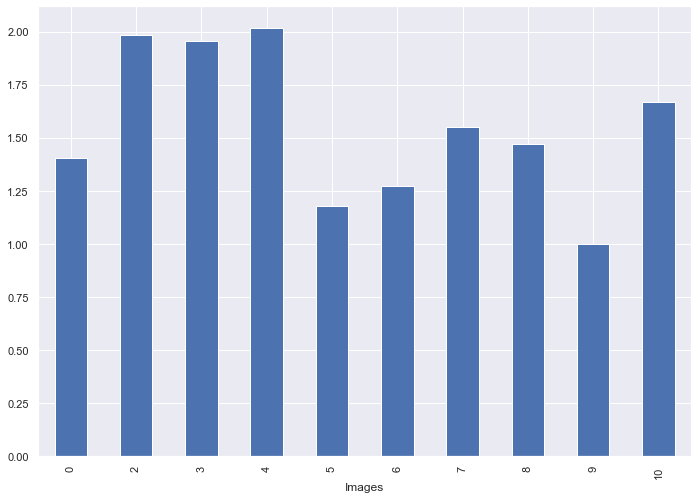

Животные


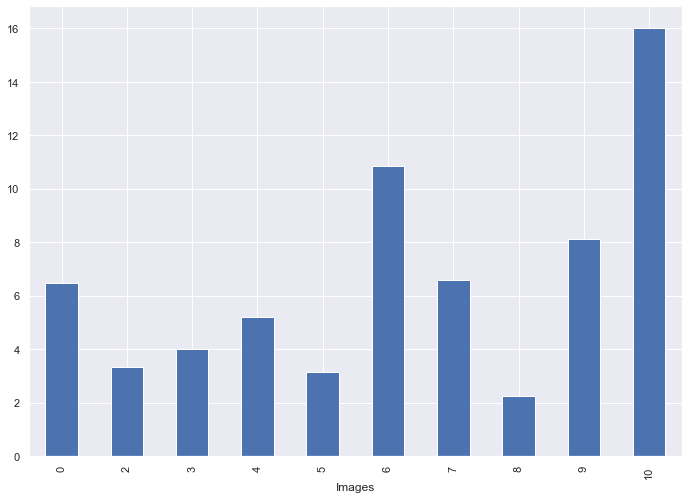

Спорт и отдых


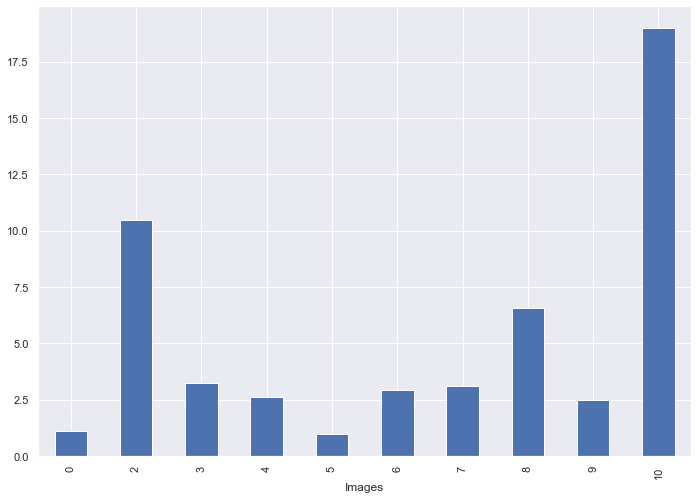

Легковые автомобили


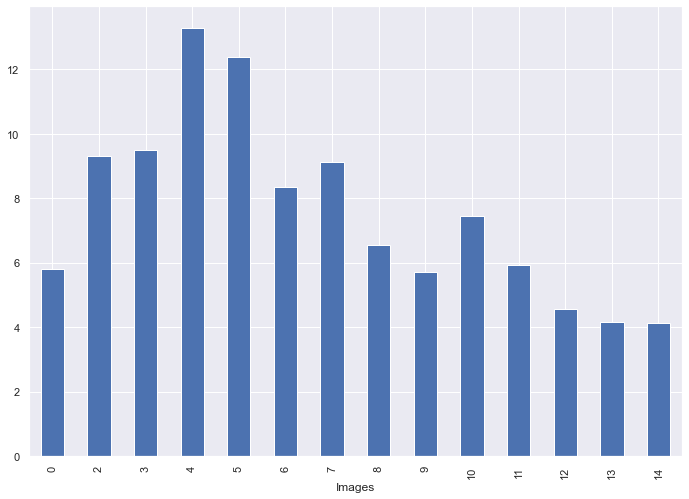

Для дома и дачи


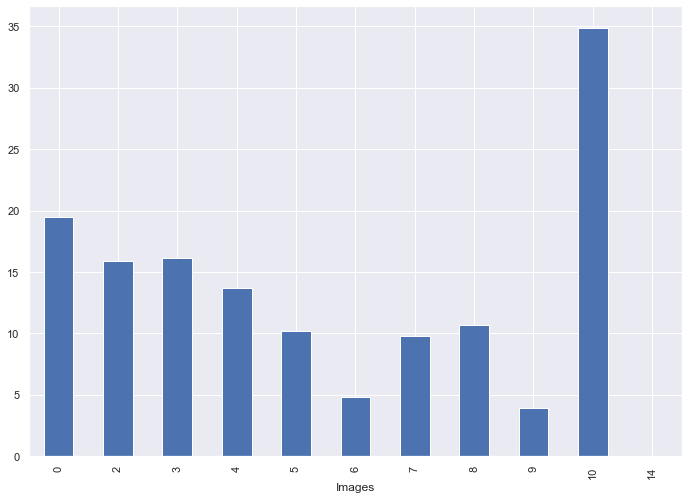

Женский гардероб


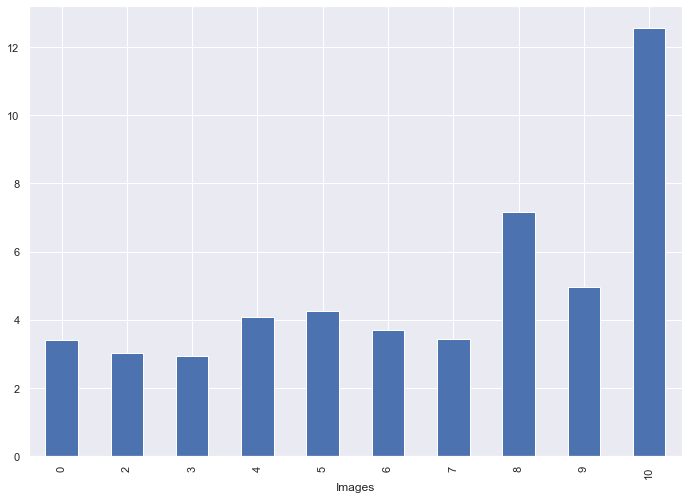

Хобби и развлечения


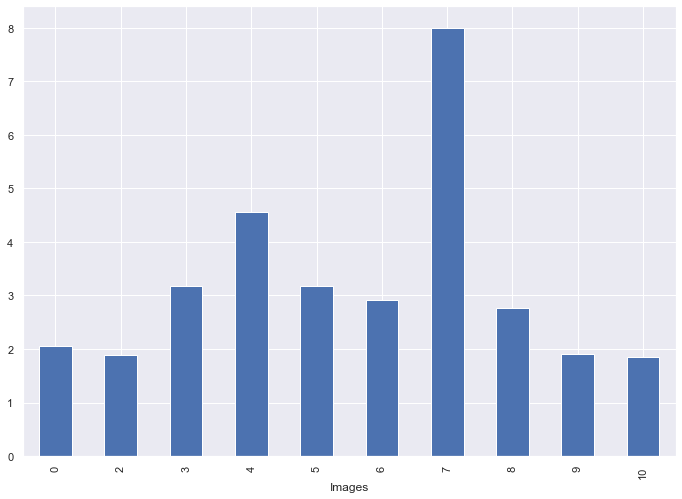

Недвижимость


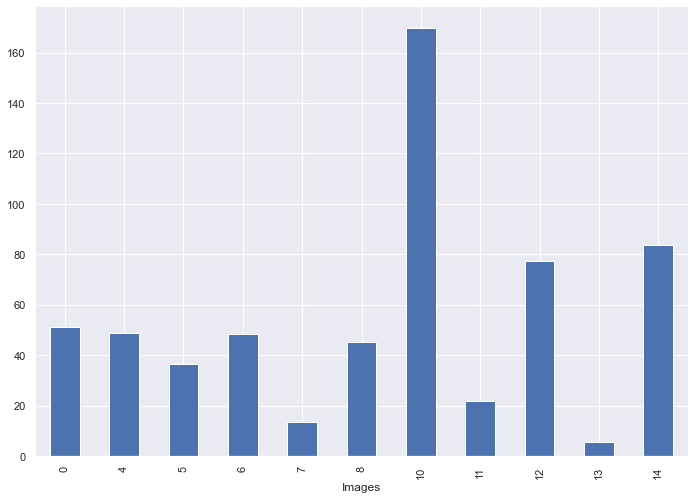

Бытовая техника


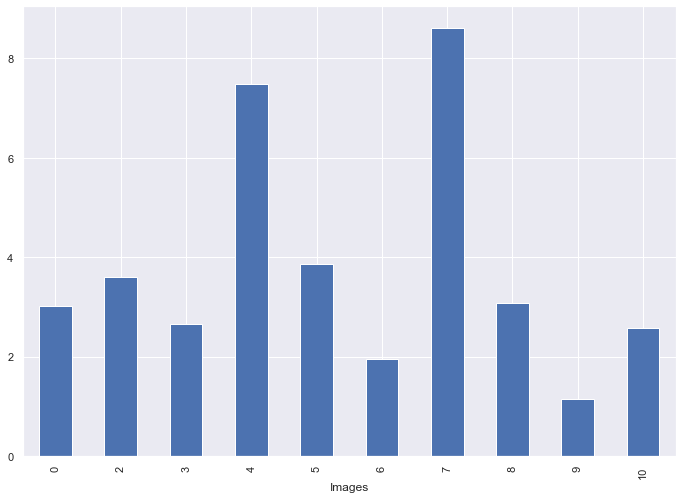

Телефоны и планшеты


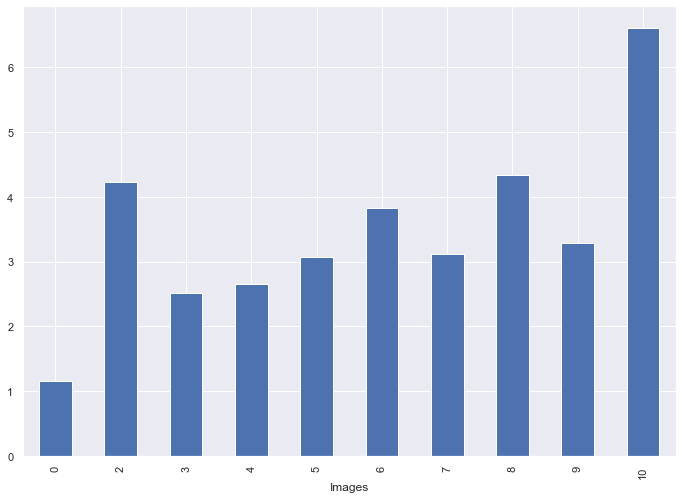

Стройматериалы и инструменты


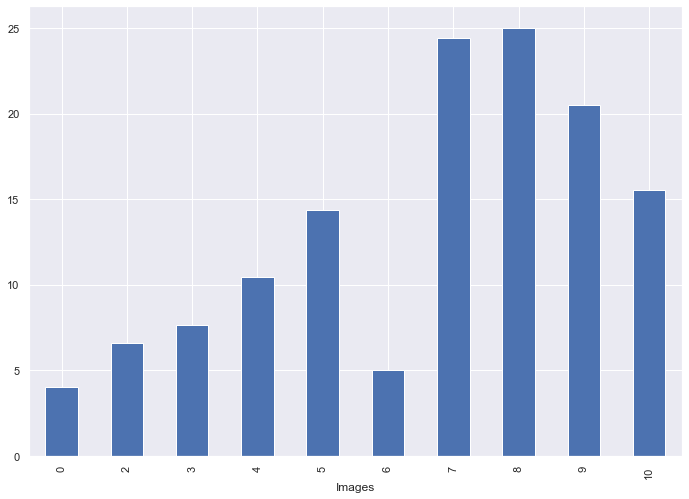

Услуги исполнителей


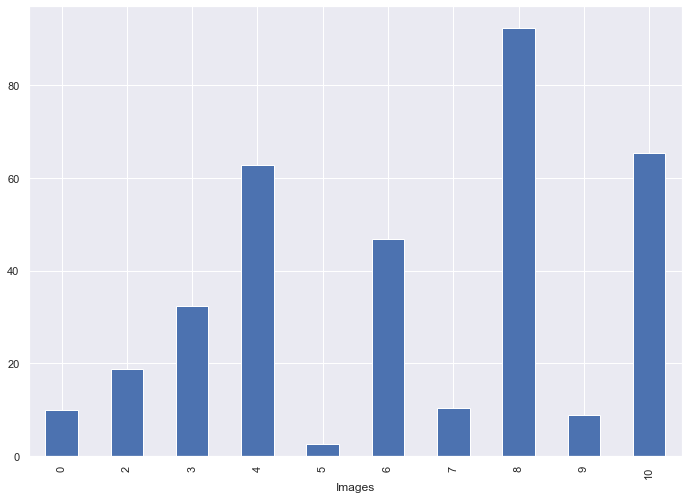

Мужской гардероб


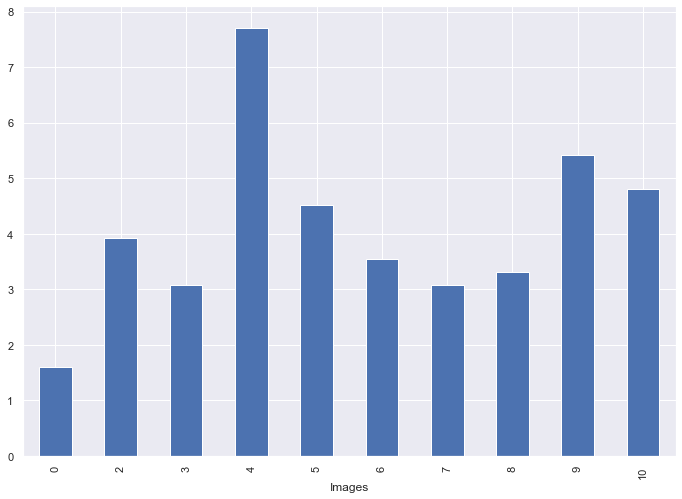

Красота и здоровье


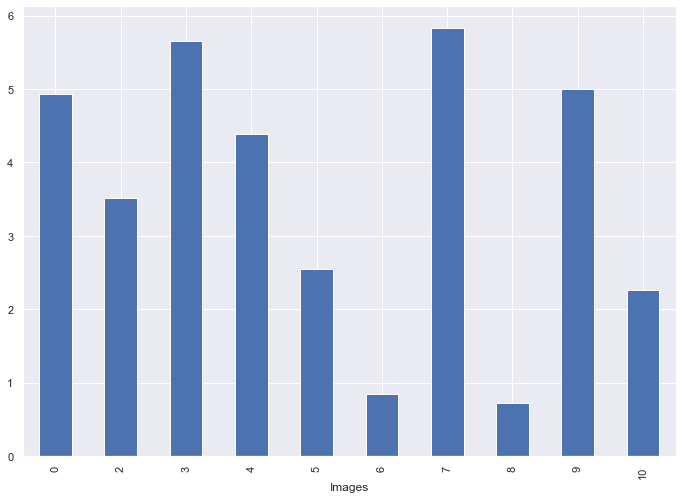

Компьютерная техника


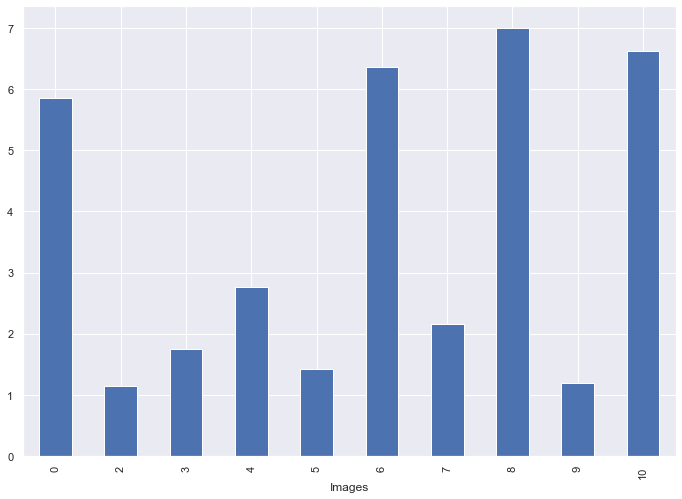

ТВ, аудио, видео


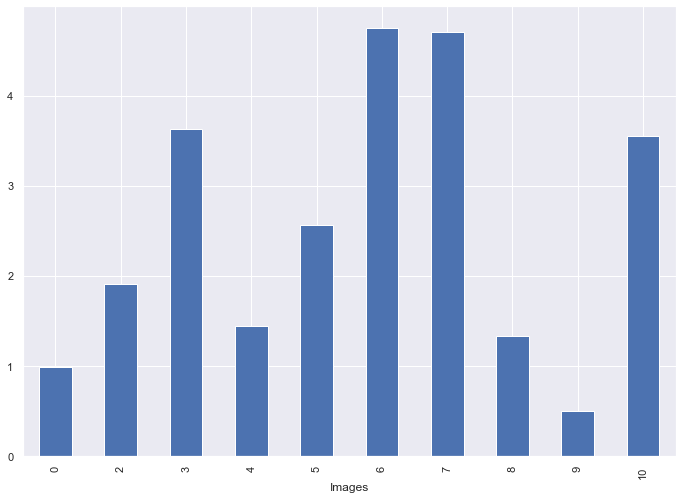

Детские товары


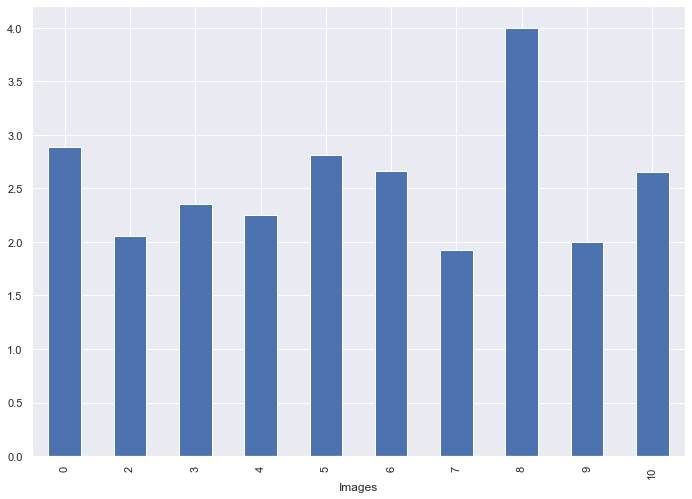

Хэндмейд


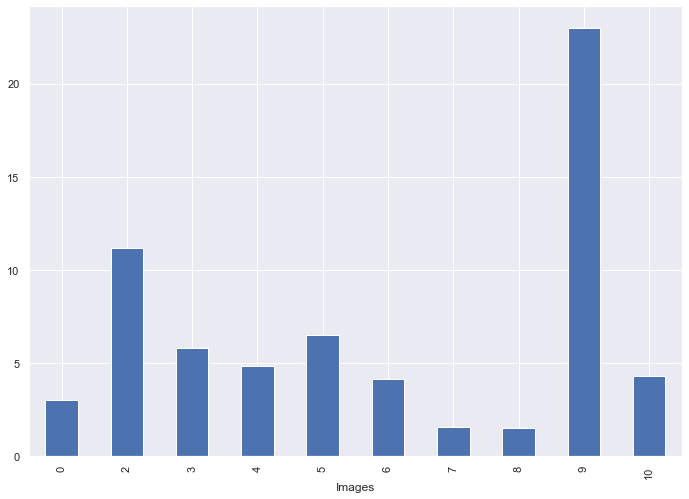

Запчасти и автотовары


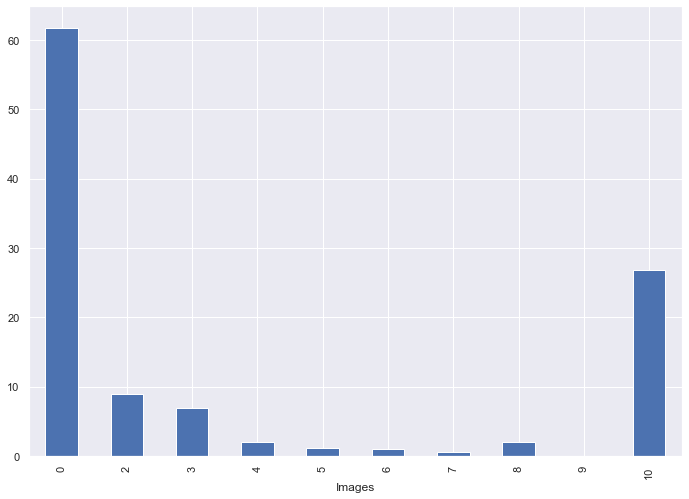

Вакансии


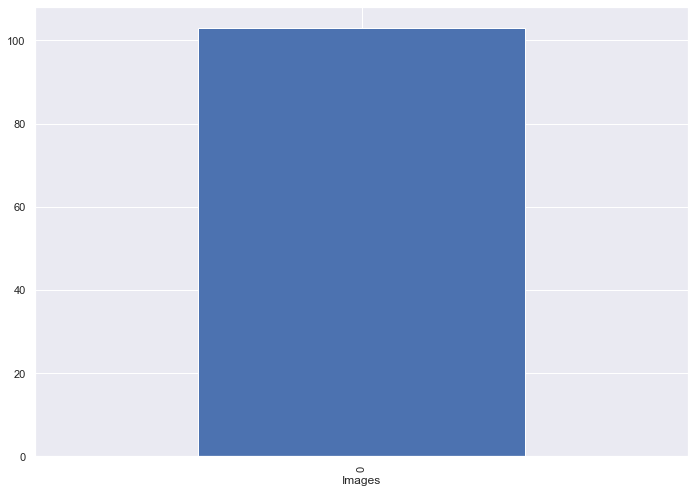

Спецтехника и мотоциклы


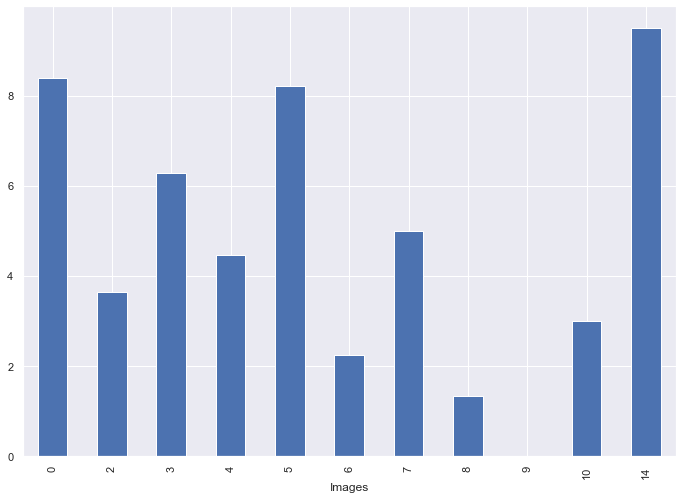

Фото- и видеокамеры


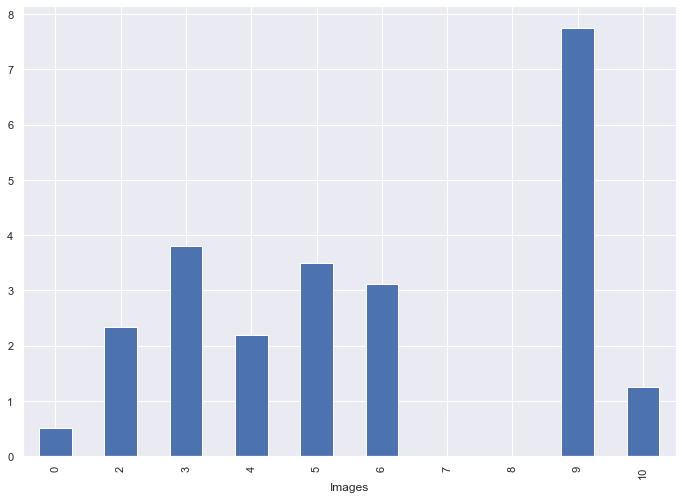

Для бизнеса


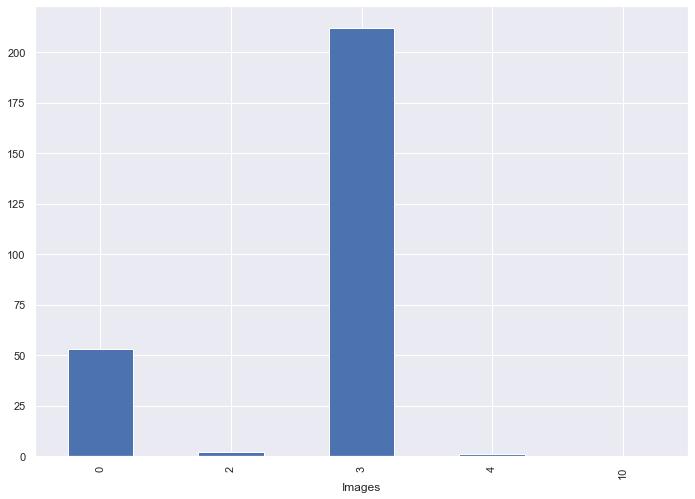

In [195]:
for cat in df["Category"].unique():
    print(cat)
    df[df["Category"] == cat].groupby("Images")["Favourites_count"].mean().plot(kind = "bar")
    plt.show()

<i>Гипотеза не подтвердилась</i> Нужно еще анализировать, можно по отдельным категориям выводы сделать и еще по абсолютным значениям посмотреть вместо процентов

<h4><b>H6. </b> Средняя цена товаров в Москве выше средней цены в других регионах</h4>

<AxesSubplot: title={'center': 'Средняя цена товаров по регионам'}, xlabel='Region'>

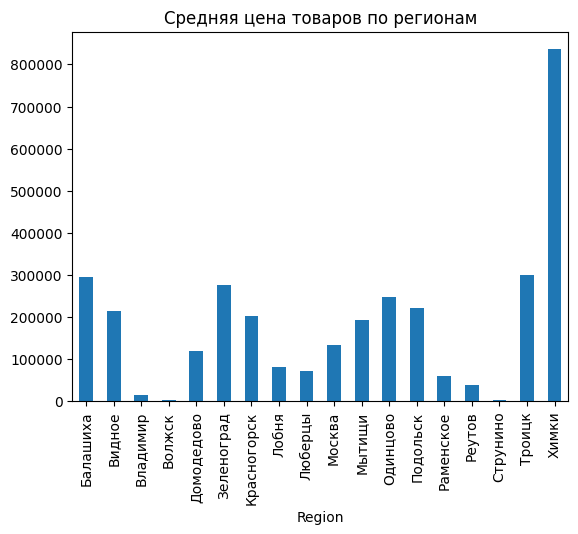

In [18]:

flags = [("Москва" in i) for i in dfRegion["Region"]]

dfRegion[dfRegion["Region"].isin(multipleOccurences)].groupby("Region")["Price"].mean().plot(kind='bar', title="Средняя цена товаров по регионам")
#dfRegion[dfRegion["Region"] == "Химки"].head(20)



<i>Гипотеза не подтвердилась</i> - есть много регионов, средняя цена товаров в которых превышает среднюю цену товаров в Москве.  
В ходе проверки данной гипотезы были получены данные, не соответствующие ожиданиям - средняя цена в определенных регионах значительно превосходит среднюю цену в столице, особенно это заметно в Химках, где средняя цена товаров и услуг составляет порядка 800000 рублей.  

Посмортим, что вызывает столь резкое отклонение средней цены в городе Химки. Для этого выведем теблицу, в которой представлены лишь товары из этого региона и установим причину.

In [21]:
dfRegion[dfRegion["Region"] == "Химки"].tail(10)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
10161,"Ford Mondeo, 2012",575000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:24:00,3.0,177.0,NaN,9.0,14,https://youla.ru/himki/auto/s-probegom/ford-mo...,33.333333,False
10245,"Hyundai Sonata, 2019",1699000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:24:00,2.0,177.0,NaN,13.0,14,https://youla.ru/himki/auto/s-probegom/hyundai...,15.384615,False
10335,"ВАЗ (Lada) 2109, 2003",45555.0,expensive,Легковые автомобили,Химки,2023-01-14 12:00:00,23.0,1.0,NaN,849.0,5,https://youla.ru/himki/auto/s-probegom/vaz-lad...,2.709069,False
10421,"Kia Optima, 2019",950000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:25:00,1.0,177.0,NaN,30.0,14,https://youla.ru/himki/auto/s-probegom/kia-opt...,3.333333,False
10466,"Kia Cee'd, 2007",450000.0,luxury,Легковые автомобили,Химки,2023-02-01 19:24:00,0.0,178.0,NaN,22.0,7,https://youla.ru/himki/auto/s-probegom/kia-cee...,0.000000,False
10560,"Mercedes-Benz M-Класс, 2006",500000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:25:00,4.0,178.0,NaN,57.0,14,https://youla.ru/himki/auto/s-probegom/mercede...,7.017544,False
10609,"Kia Sorento, 2010",750000.0,luxury,Легковые автомобили,Химки,2023-02-01 02:23:00,1.0,178.0,NaN,157.0,13,https://youla.ru/himki/auto/s-probegom/kia-sor...,0.636943,False
10763,"Geely Coolray, 2020",850000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:26:00,2.0,176.0,NaN,18.0,14,https://youla.ru/himki/auto/s-probegom/geely-c...,11.111111,False
10805,"Kia Rio, 2010",349000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:24:00,7.0,178.0,NaN,157.0,11,https://youla.ru/himki/auto/s-probegom/kia-rio...,4.458599,False
10851,"Volkswagen Polo, 2012",435000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:25:00,1.0,178.0,NaN,18.0,14,https://youla.ru/himki/auto/s-probegom/volkswa...,5.555556,False


Несложно заметить, что значительную часть товаров в данном городе составляют товары роскоши, а именно легковые автомобили